# CNN
Training auf IDS17 80%  
Validierung auf IDS17 10%   
Test auf IDS17 10%  
Test auf IDS18 mit reduzierten Benign Daten folgt in cnn_test

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import plot_model


2024-10-30 12:58:23.906565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 12:58:23.925762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 12:58:23.938896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 12:58:23.942961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 12:58:23.958796: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS17

In [3]:
# IDS17 Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(os.path.join(parquet_verzeichnis_ids17 + '_prep_0'))
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

2024-10-30 12:58:30 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Web Attack - Brute Force             73
Web Attack - XSS                     18
Web Attack - SQL                     13
Name: count, dtype: int64


In [ ]:
print(ids17.shape)
print(ids17.columns)

### Trennen von Features und Labels

In [ ]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923167, 83)
Form von y: (1923167,)


### Label Encoding für y

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

### Skallierung von X

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

### Umformen der Daten für das CNN

In [17]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (1923167, 83, 1)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [18]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reshaped, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)

Form von X_train: (1538533, 83, 1)
Form von X_val: (192317, 83, 1)
Form von X_test: (192317, 83, 1)


### Überprüfen der Klassenverteilung

In [19]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 1266048 Beispiele (82.29%)
  Klasse 1: 589 Beispiele (0.04%)
  Klasse 2: 76115 Beispiele (4.95%)
  Klasse 3: 6054 Beispiele (0.39%)
  Klasse 4: 126774 Beispiele (8.24%)
  Klasse 5: 3087 Beispiele (0.20%)
  Klasse 6: 57414 Beispiele (3.73%)
  Klasse 7: 2369 Beispiele (0.15%)
  Klasse 8: 58 Beispiele (0.00%)
  Klasse 9: 11 Beispiele (0.00%)
  Klasse 10: 14 Beispiele (0.00%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 158257 Beispiele (82.29%)
  Klasse 1: 74 Beispiele (0.04%)
  Klasse 2: 9514 Beispiele (4.95%)
  Klasse 3: 756 Beispiele (0.39%)
  Klasse 4: 15847 Beispiele (8.24%)
  Klasse 5: 386 Beispiele (0.20%)
  Klasse 6: 7176 Beispiele (3.73%)
  Klasse 7: 296 Beispiele (0.15%)
  Klasse 8: 8 Beispiele (0.00%)
  Klasse 9: 1 Beispiele (0.00%)
  Klasse 10: 2 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 158256 Beispiele (82.29%)
  Klasse 1: 73 Beispiele (0.04%)
  Klasse 2: 9515 Beispiele (4.95%)
  Klasse

 ### Modell erstellen und trainieren

In [20]:
def create_cnn_model(num_features, num_classes):
    inputs = keras.layers.Input(shape=(num_features, 1))
    x = keras.layers.Conv1D(120, kernel_size=2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv1D(60, kernel_size=3, activation='relu', padding="same")(x)
    x = keras.layers.Conv1D(30, kernel_size=4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Kompilieren des Modells
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

# Anzahl der Klassen (Labels)
num_classes = len(label_encoder.classes_)

# Modell erstellen
cnn_model = create_cnn_model(num_features, num_classes)
cnn_model.summary()


I0000 00:00:1730274427.391955  755142 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730274427.423353  755142 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730274427.423414  755142 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730274427.425919  755142 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730274427.425956  755142 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 83, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 83, 120)        │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 60)         │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 83, 30)         │         7,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2490)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        27,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,651 (221.29 KB)

 Trainable params: 56,651 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [21]:
cnn_model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/2


I0000 00:00:1730274758.446843  758212 service.cc:146] XLA service 0x7f152c015af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730274758.446889  758212 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-30 08:52:38.460619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 08:52:38.531846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  125/48080 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step - loss: 0.7590 - sparse_categorical_accuracy: 0.8685      

I0000 00:00:1730274759.837264  758212 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48080/48080 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0014 - val_sparse_categorical_accuracy: 0.9997
Epoch 2/2
48080/48080 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.9997 - val_loss: 6.4006e-04 - val_sparse_categorical_accuracy: 0.9998


### Evaluierung des Modells auf dem Testdatensatz

In [22]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

6010/6010 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 6.7076e-04 - sparse_categorical_accuracy: 0.9998
Testverlust: 0.0008
Testgenauigkeit: 0.9998


### Klassifikationsbericht und eine Konfusionsmatrix

In [ ]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

Visualisierung der Konfusionsmatrix

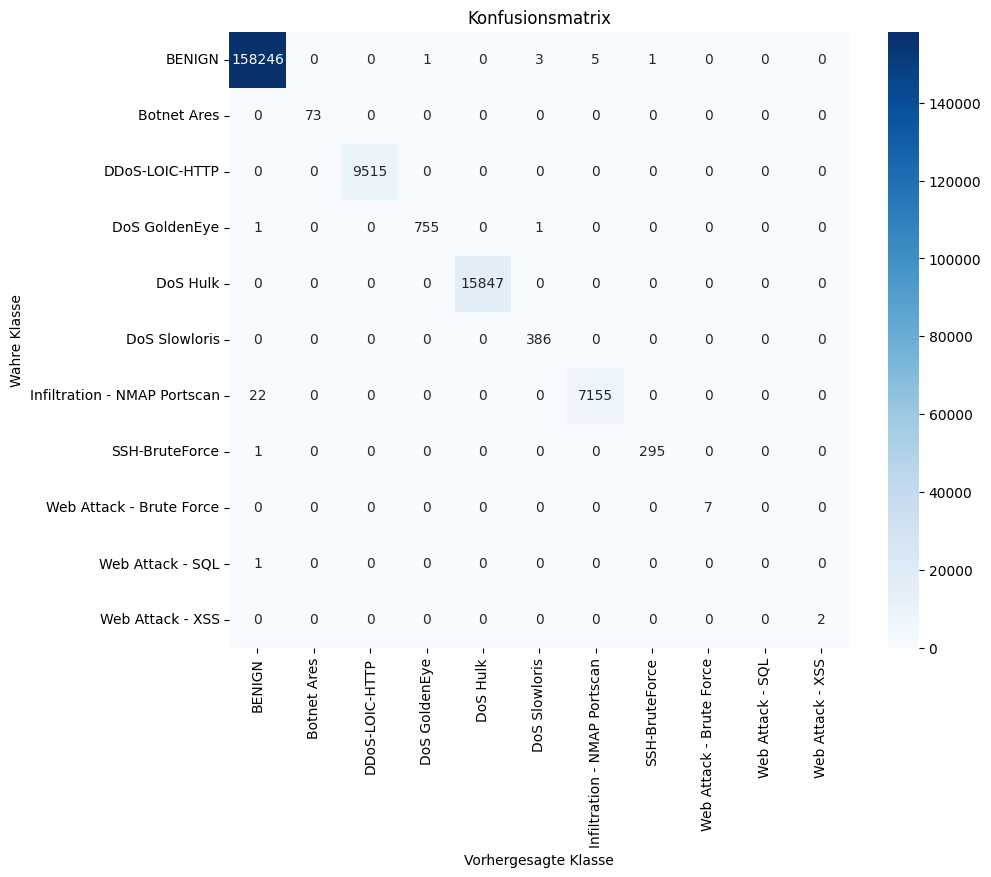

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [25]:
# Speichern des Modells
cnn_model.save('ids17_cnn_model.h5')

# Speichern des Label Encoders und Scalers
import joblib

joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Sonstiges

### Wichtige Überlegungen
- Hyperparameter-Tuning: Experimentieren Sie mit der Anzahl der Epochen, der Batch-Größe, der Lernrate und anderen Hyperparametern, um die Modellleistung zu verbessern.
- Klassengewichtung: Wenn Ihr Datensatz unausgewogen ist, können Sie Klassengewichte verwenden, um das Modell zu sensibilisieren.
- Cross-Validation: Für eine robustere Bewertung könnten Sie Kreuzvalidierungstechniken anwenden.
- Feature-Engineering: Überlegen Sie, ob zusätzliche Feature-Auswahl oder -Extraktion die Leistung verbessern könnte.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Beim Training des Modells
cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)
